In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg 
import keras 
import tensorflow as tf
from keras.models import Sequential 
from tensorflow.keras.optimizers import Adam 
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense 
from sklearn.utils import shuffle 
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa 
import cv2
import pandas as pd 
import ntpath 
import random

In [39]:
# Load Train Data

datadir = "data"
columns = ["center", "left", "right", "steering", "throttle", "reverse", "speed"]
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names=columns)
pd.set_option('display.max_colwidth', -1)
data.head()

center  \
0  C:\Users\YSH\Documents\OurAICar\simulation\simple\data\IMG\center_2022_02_22_12_44_40_526.jpg   
1  C:\Users\YSH\Documents\OurAICar\simulation\simple\data\IMG\center_2022_02_22_12_44_40_598.jpg   
2  C:\Users\YSH\Documents\OurAICar\simulation\simple\data\IMG\center_2022_02_22_12_44_40_670.jpg   
3  C:\Users\YSH\Documents\OurAICar\simulation\simple\data\IMG\center_2022_02_22_12_44_40_737.jpg   
4  C:\Users\YSH\Documents\OurAICar\simulation\simple\data\IMG\center_2022_02_22_12_44_40_809.jpg   

                                                                                          left  \
0  C:\Users\YSH\Documents\OurAICar\simulation\simple\data\IMG\left_2022_02_22_12_44_40_526.jpg   
1  C:\Users\YSH\Documents\OurAICar\simulation\simple\data\IMG\left_2022_02_22_12_44_40_598.jpg   
2  C:\Users\YSH\Documents\OurAICar\simulation\simple\data\IMG\left_2022_02_22_12_44_40_670.jpg   
3  C:\Users\YSH\Documents\OurAICar\simulation\simple\data\IMG\left_2022_02_22_12_44_40_737.jpg   
4  C:\Users\YSH\Documents\OurAICar\simulation\simple\data\IMG\left_2022_02_22_12_44_40_809.jpg   

                                                                                          right  \
0  C:\Users\YSH\Documents\OurAICar\simulation\simple\data\IMG\right_2022_02_22_12_44_40_526.jpg   
1  C:\Users\YSH\Documents\OurAICar\simulation\simple\data\IMG\right_2022_02_22_12_44_40_598.jpg   
2  C:\Users\YSH\Documents\OurAICar\simulation\simple\data\IMG\right_2022_02_22_12_44_40_670.jpg   
3  C:\Users\YSH\Documents\OurAICar\simulation\simple\data\IMG\right_2022_02_22_12_44_40_737.jpg   
4  C:\Users\YSH\Documents\OurAICar\simulation\simple\data\IMG\right_2022_02_22_12_44_40_809.jpg   

   steering  throttle  reverse     speed  
0  0.00      0.0       0.0      5.951196  
1  0.00      0.0       0.0      5.903379  
2  0.00      0.0       0.0      5.855948  
3  0.00      0.0       0.0      5.820624  
4 -0.05      0.0       0.0      5.785095

## Image Path Edit

Split the src of the image to load image appropriate.

In [3]:
def path_leaf(path): 
    head, tail = ntpath.split(path)
    return tail

In [4]:
print(path_leaf('C:/Users/YSH/Documents/OurAICar/simulation/simple/data/IMG/center_2022_02_22_12_44_40_809.jpg'))

center_2022_02_22_12_44_40_809.jpg


In [40]:
data["center"] = data["center"].apply(path_leaf)
data["left"] = data["left"].apply(path_leaf)
data["right"] = data["right"].apply(path_leaf)
data.head()

center                              left  \
0  center_2022_02_22_12_44_40_526.jpg  left_2022_02_22_12_44_40_526.jpg   
1  center_2022_02_22_12_44_40_598.jpg  left_2022_02_22_12_44_40_598.jpg   
2  center_2022_02_22_12_44_40_670.jpg  left_2022_02_22_12_44_40_670.jpg   
3  center_2022_02_22_12_44_40_737.jpg  left_2022_02_22_12_44_40_737.jpg   
4  center_2022_02_22_12_44_40_809.jpg  left_2022_02_22_12_44_40_809.jpg   

                               right  steering  throttle  reverse     speed  
0  right_2022_02_22_12_44_40_526.jpg  0.00      0.0       0.0      5.951196  
1  right_2022_02_22_12_44_40_598.jpg  0.00      0.0       0.0      5.903379  
2  right_2022_02_22_12_44_40_670.jpg  0.00      0.0       0.0      5.855948  
3  right_2022_02_22_12_44_40_737.jpg  0.00      0.0       0.0      5.820624  
4  right_2022_02_22_12_44_40_809.jpg -0.05      0.0       0.0      5.785095

## Train Data Optimization

Data distribution is distorted and we have to optimize it

In [43]:
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data["steering"], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5

total data: 6541


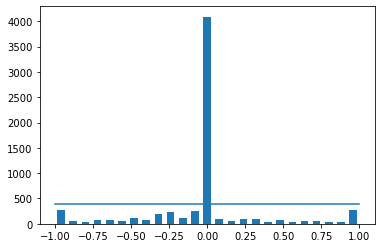

In [44]:
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data["steering"]), np.max(data["steering"])), (samples_per_bin, samples_per_bin))
print(f"total data: {len(data)}")

In [45]:
remove_list = []
for j in range(num_bins):
    list_ = []
    for i in range(len(data["steering"])):
        if data["steering"][i] >= bins[j] and data["steering"][i] <= bins[j+1]:
            list_.append(i)
            
    list_ = shuffle(list_)
    list_ = list_[samples_per_bin:]
    remove_list.extend(list_)

In [46]:
print(f"removed: {len(remove_list)}")
data.drop(data.index[remove_list], inplace=True)
print(f"remaining: {len(data)}")

removed: 3691
remaining: 2850


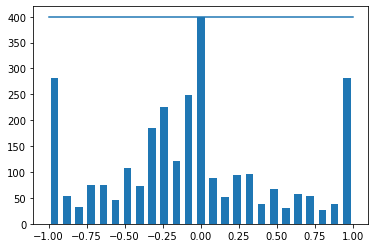

In [47]:
hist, _ = np.histogram(data["steering"], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data["steering"]), np.max(data["steering"])), (samples_per_bin, samples_per_bin))

In [13]:
print(data.iloc[1])

center      center_2022_02_22_12_44_40_809.jpg
left        left_2022_02_22_12_44_40_809.jpg  
right       right_2022_02_22_12_44_40_809.jpg 
steering   -0.05                              
throttle    0.0                               
reverse     0                                 
speed       5.785095                          
Name: 4, dtype: object


## Load Image

Loading Image and Augment it to extend dataset.

In [48]:
# Load Center, Left, Right Image and Steering data 
def load_img_steering(datadir, df):
    image_path = []
    steering = []
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
        image_path.append(os.path.join(datadir,center.strip()))
        steering.append(float(indexed_data[3]))
        
        # Left image append 
        image_path.append(os.path.join(datadir,left.strip()))
        steering.append(float(indexed_data[3]) + 0.15)
    
        # Right image append 
        image_path.append(os.path.join(datadir,right.strip()))
        steering.append(float(indexed_data[3] - 0.15))
        
        
    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)
    return image_paths, steerings


In [49]:
image_paths, steerings = load_img_steering(datadir + '/IMG', data)
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print(f'Training Samples: {len(X_train)}\nValid Samples: {len(X_valid)}')

Training Samples: 6840
Valid Samples: 1710


Text(0.5, 1.0, 'Validation set')

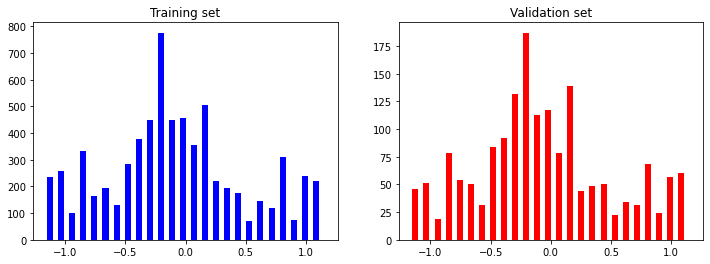

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [17]:
# Image Augment - zoom
def zoom(image):
    zoom = iaa.Affine(scale=(1, 1.3))
    image = zoom.augment_image(image)
    return image

image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

Text(0.5, 1.0, 'Zoomed Image')

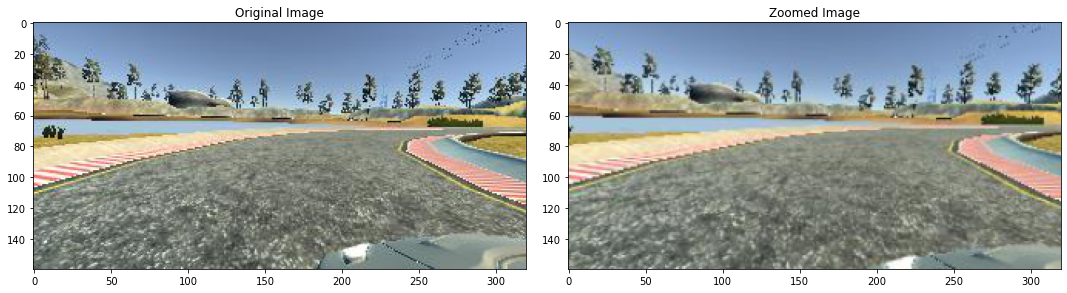

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title("Original Image")
axs[1].imshow(zoomed_image)
axs[1].set_title("Zoomed Image")

In [19]:
# Image Augment - pan
def pan(image):
    pan = iaa.Affine(translate_percent={"x":(-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image

image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

Text(0.5, 1.0, 'Panned Image')

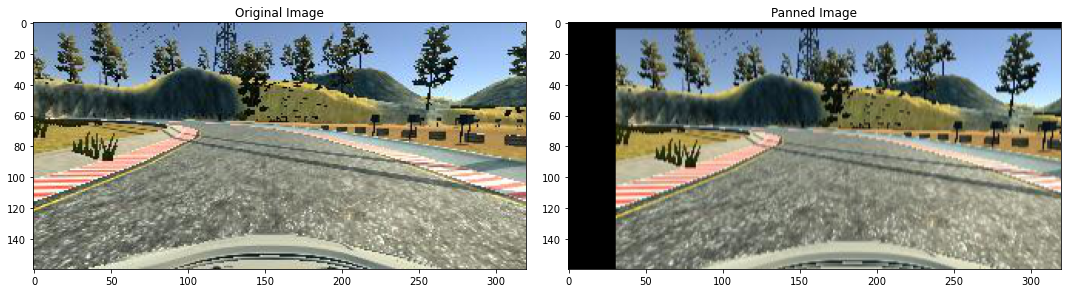

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

In [21]:
# Image Augment - Brightness
def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)

Text(0.5, 1.0, 'Brightness altered image ')

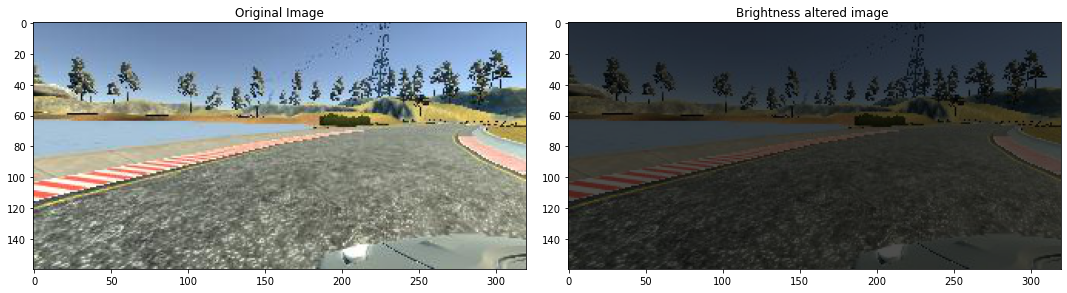

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image ')

In [23]:
def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle

random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]

In [24]:
original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

Text(0.5, 1.0, 'Flipped Image - Steering Angle:-0.0')

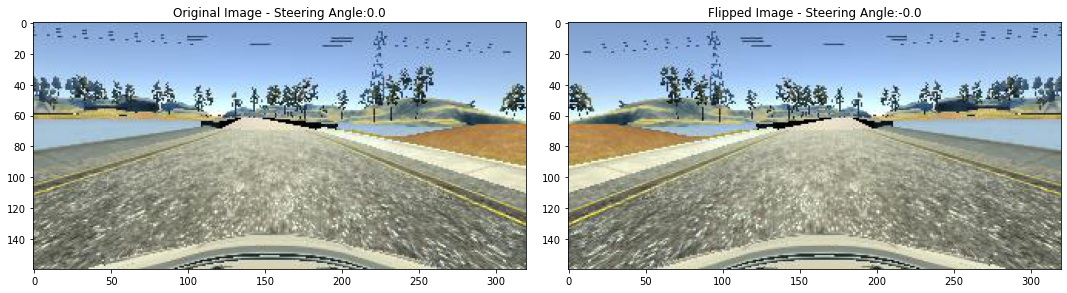

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle:' + str(steering_angle))
 
axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle:' + str(flipped_steering_angle))

In [26]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
      image = pan(image)
    if np.random.rand() < 0.5:
      image = zoom(image)
    if np.random.rand() < 0.5:
      image = img_random_brightness(image)
    if np.random.rand() < 0.5:
      image, steering_angle = img_random_flip(image, steering_angle)
    
    return image, steering_angle

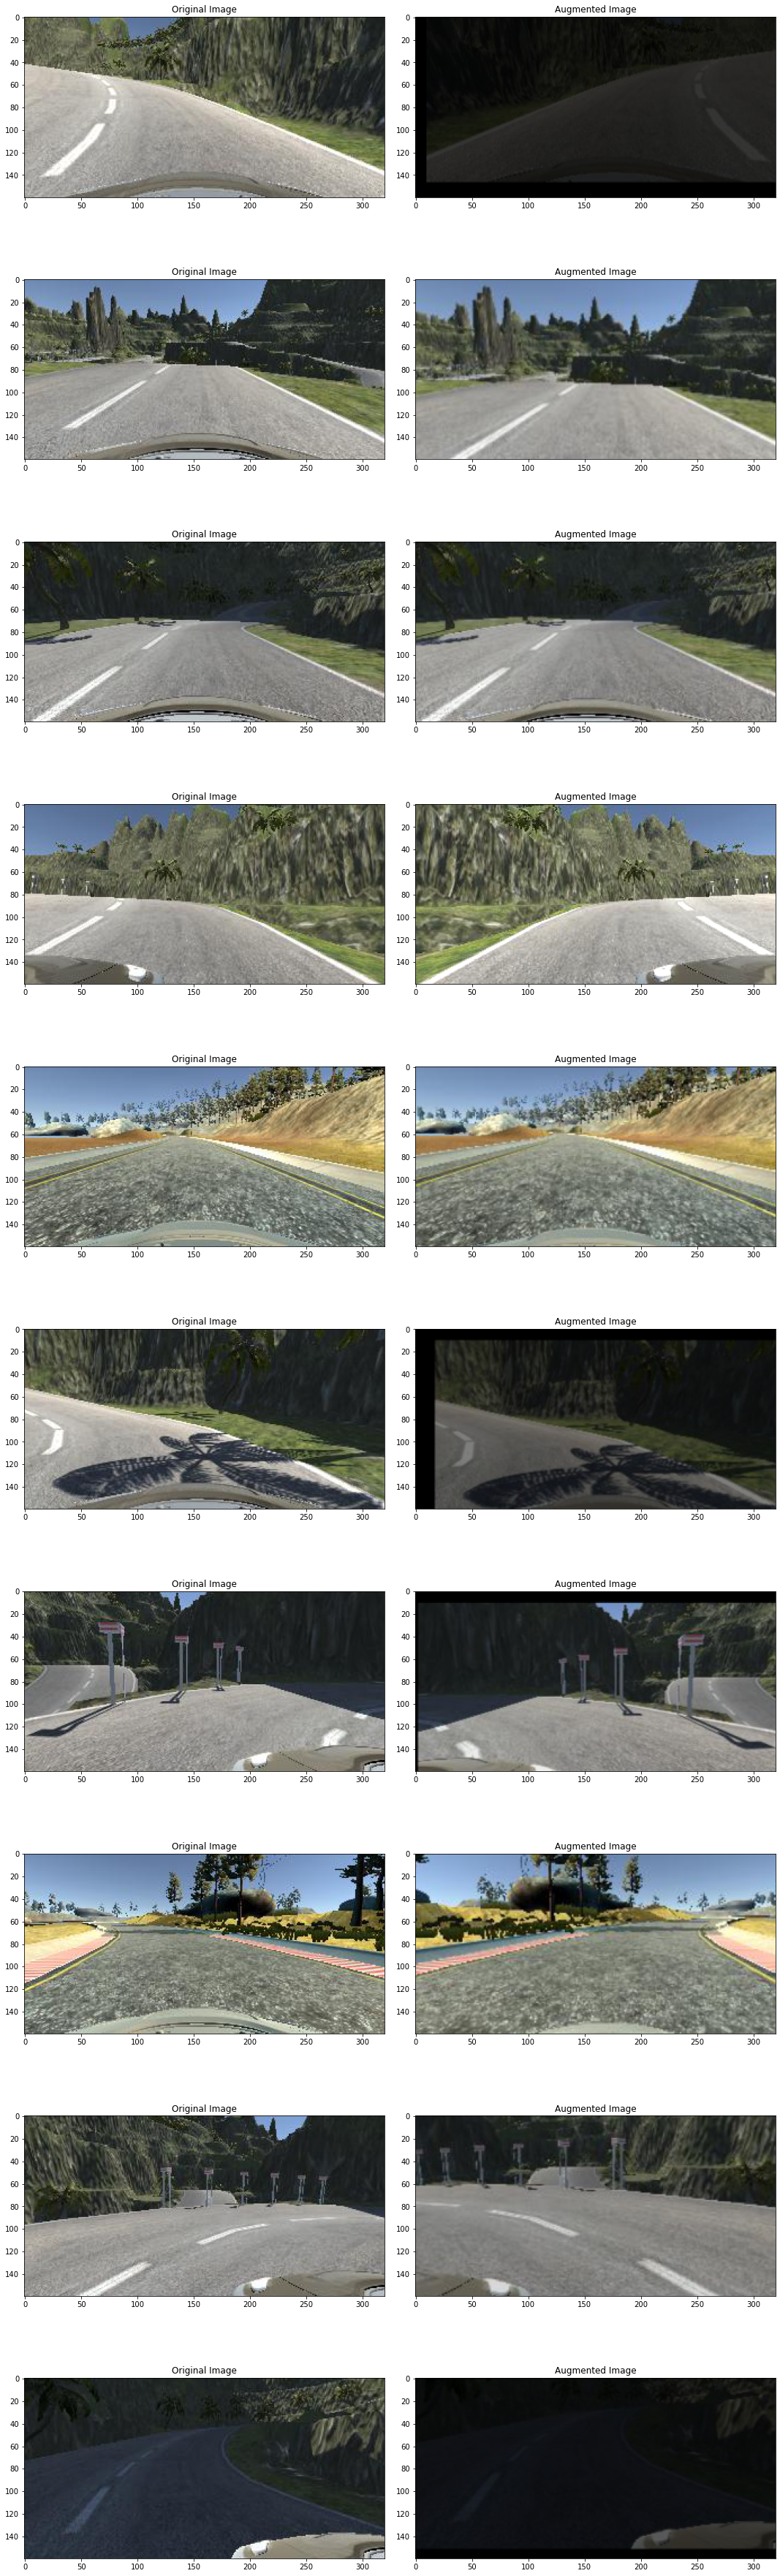

In [51]:
ncol = 2
nrow = 10
 
fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()
for i in range(10):
  randnum = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]
    
  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)
    
  axs[i][0].imshow(original_image)
  axs[i][0].set_title("Original Image")
  
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title("Augmented Image")

In [52]:
# PreProcess Image
def img_preprocess(img):
    img = img[60:135, :, :]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img / 255 
    return img

In [53]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

Text(0.5, 1.0, 'Preprocessed Image')

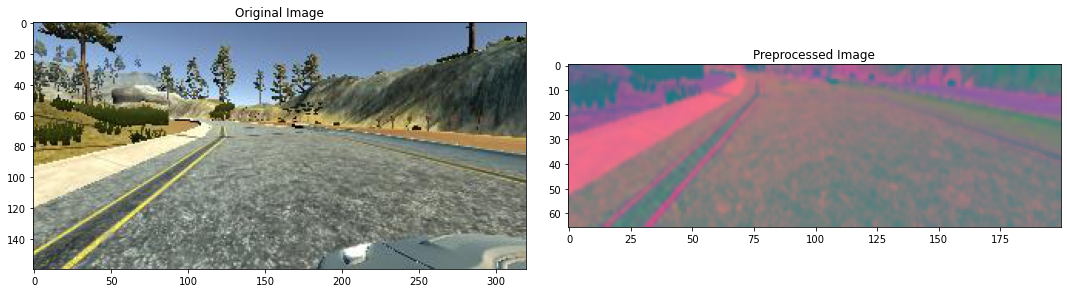

In [54]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [55]:
# batch generator
def batch_generator(image_paths, steering_ang, batch_size, istraining):
      
  while True:
    batch_img = []
    batch_steering = []
    
    for _ in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
     
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      
      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))  

In [56]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

Text(0.5, 1.0, 'Validation Image')

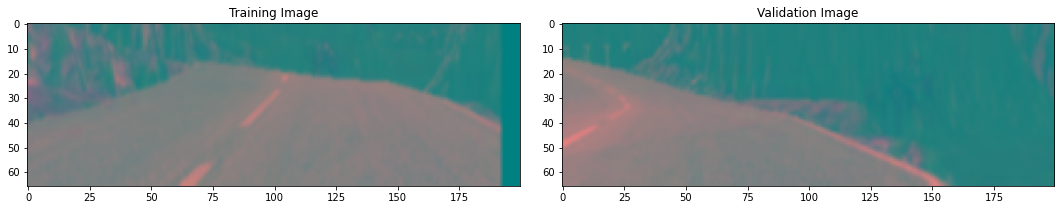

In [57]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')
 
axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

In [58]:
def nvidia_model():
    model = Sequential()
    model.add(Conv2D(24, kernel_size=(5, 5), strides=(2,2), input_shape=(66, 200, 3), activation="relu"))
    model.add(Conv2D(36, kernel_size=(5, 5), strides=(2,2), activation="relu"))
    model.add(Conv2D(48, kernel_size=(5, 5), strides=(2,2), activation="relu"))
    model.add(Conv2D(64, kernel_size=(3, 3), activation="relu"))
    model.add(Conv2D(64, kernel_size=(3, 3), activation="relu"))
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(100, activation="relu"))
    model.add(Dropout(0.5))
    
    model.add(Dense(50, activation="relu"))
    model.add(Dense(10, activation="relu"))
    model.add(Dense(1))
    
    optimizer = Adam(learning_rate=1e-3)

    model.compile(loss="mse", optimizer=optimizer)
    model.summary()
    return model

In [59]:
model = nvidia_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 31, 98, 24)        1824      
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_7 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_8 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 conv2d_9 (Conv2D)           (None, 1, 18, 64)         36928     
                                                                 
 dropout_2 (Dropout)         (None, 1, 18, 64)         0         
                                                                 
 flatten_1 (Flatten)         (None, 1152)             

In [60]:
model.build(input_shape=(None, 66, 200, 3))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 31, 98, 24)        1824      
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_7 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_8 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 conv2d_9 (Conv2D)           (None, 1, 18, 64)         36928     
                                                                 
 dropout_2 (Dropout)         (None, 1, 18, 64)         0         
                                                                 
 flatten_1 (Flatten)         (None, 1152)             

In [62]:
from keras.callbacks import ModelCheckpoint, EarlyStopping 

# filename = "checkpoint-epoch-{}-batch-{}-trial-001.h5".format(EPOCH, BATCH_SIZE)

checkpoint = ModelCheckpoint("best_model.h5", monitor='val_loss', verbose=1, save_best_only=True, model="auto")

earlystopping = EarlyStopping(monitor="val_loss", patience=2)



In [64]:
history = model.fit(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=500, 
                                  epochs=10,
                                  validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps=400,
                                  verbose=1,
                                  shuffle = 1, 
                                  callbacks=[checkpoint, earlystopping])

Epoch 1/10
500/500 [==============================] - ETA: 0s - loss: 0.1712
Epoch 1: val_loss improved from 0.15964 to 0.13403, saving model to best_model.h5
500/500 [==============================] - 181s 362ms/step - loss: 0.1712 - val_loss: 0.1340
Epoch 2/10
500/500 [==============================] - ETA: 0s - loss: 0.1585
Epoch 2: val_loss improved from 0.13403 to 0.12456, saving model to best_model.h5
500/500 [==============================] - 181s 363ms/step - loss: 0.1585 - val_loss: 0.1246
Epoch 3/10
500/500 [==============================] - ETA: 0s - loss: 0.1501
Epoch 3: val_loss did not improve from 0.12456
500/500 [==============================] - 181s 362ms/step - loss: 0.1501 - val_loss: 0.1408
Epoch 4/10
500/500 [==============================] - ETA: 0s - loss: 0.1451
Epoch 4: val_loss improved from 0.12456 to 0.11516, saving model to best_model.h5
500/500 [==============================] - 180s 362ms/step - loss: 0.1451 - val_loss: 0.1152
Epoch 5/10
500/500 [=======

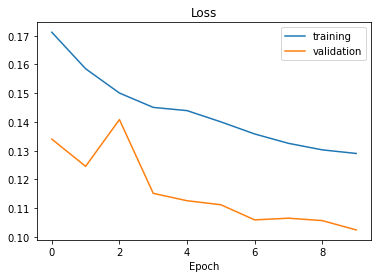

In [65]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')
model.save('model-advance2.h5')